In [2]:
import os

import numpy as np
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
#Interquartile Range Method
def remove_outliers(arr):
    quartile_1, quartile_3 = np.percentile(arr, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    filtered_arr = [x for x in arr if lower_bound <= x <= upper_bound]
    return filtered_arr if filtered_arr else np.nan
def zscore_create_outliers_mask(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)  # Berechne den absoluten Z-Score für jeden Datenpunkt
    return z_scores < threshold  # True für Datenpunkte innerhalb des Schwellenwerts, False für Ausreißer

In [4]:
#Setup Database
load_dotenv()
uri = os.environ['DB_URI']
client = MongoClient(uri)
db = client["rosen"]
collection = db["big_data_2"]

In [5]:
documents = collection.find({}, {"_id": 1, "instrument": 1, "configuration": 1, "velocity": 1})
average_velocities = pd.DataFrame(list(documents))

In [6]:
average_velocities['velocity'] = average_velocities['velocity'].apply(lambda x: np.mean(remove_outliers(x)))

In [8]:
outliers = zscore_create_outliers_mask(average_velocities["velocity"])
average_velocities = average_velocities[outliers]

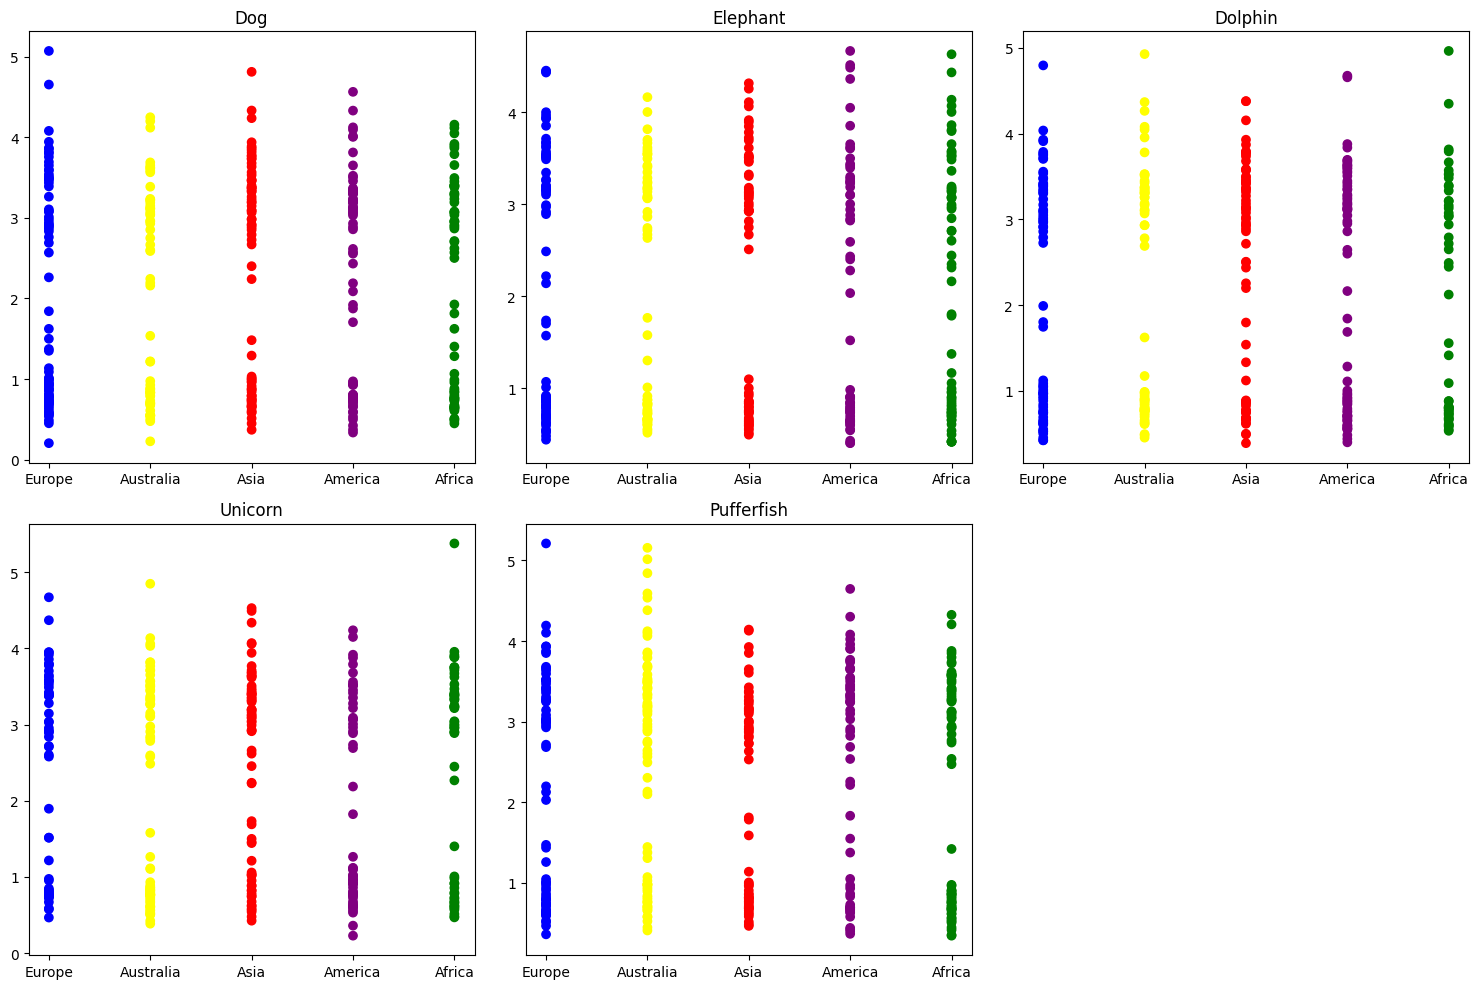

In [29]:
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
regions = collection.distinct("configuration")

colors = {"Europe": "blue", "Asia": "red", "Africa": "green", "Australia": "yellow", "America": "purple"}
average_velocities.sort_values(by="configuration", ascending=False, inplace=True)
for index, val in enumerate(average_velocities['instrument'].unique()):
    sdf = average_velocities.loc[average_velocities['instrument']==val]
    #sdf.plot(x='configuration', y='velocity', kind='scatter', title=f'Velocity of {val}')
    
    row = index // cols
    col = index % cols
    ax = axes[row, col]
    wedges = ax.scatter(sdf["configuration"], sdf["velocity"], c=sdf["configuration"].map(colors))

    ax.set_title(val)

# Layout anpassen, um Überlappungen zu verhindern und Platz für die Legende zu machen
plt.tight_layout()

# Überflüssige Subplots entfernen, falls die Anzahl der Instrumente nicht ein Vielfaches der Spaltenanzahl ist
if 5 < rows * cols:
    for idx in range(5, rows * cols):
        fig.delaxes(axes.flatten()[idx])
        
        
#ax.legend(wedges, regions, title="Regionen", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

man kann (teilweise) erkennen, dass es zwei geschwindigkeitsbereiche gibt -> gas und flüssigkeit (?)